In [1]:
import numpy as np
import os
import io
import cv2
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from densenet import densenet_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

tf.__version__

'2.2.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()


1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# hyperparameters
# data
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
horizontal_flip = True
vertical_flip = True
shear_range = 0
zoom_range = 0.5
size = (32,32)

# model
nb_filter = 64
growth_rate = 16
nb_layers = [6, 12, 24, 16]
reduction = 0.5

# training
lr = 0.001
epochs = 100
max_patience = 100
batch_size = 512

# log
log_freq = 1
models_directory = 'results/models/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "{}-growth-{}-densenet".format(
    '-'.join([str(i) for i in nb_layers]),
    growth_rate) + date

In [4]:
# Construct a tf.data.Dataset
ds_train = tfds.load('cifar100', split='train', shuffle_files=True, batch_size=-1)
train_np_ds = tfds.as_numpy(ds_train)
ds_test = tfds.load('cifar100', split='test', shuffle_files=False, batch_size=-1)
test_np_ds = tfds.as_numpy(ds_test)

x_train, y_train = train_np_ds["image"], train_np_ds["label"]
x_test, y_test = test_np_ds["image"], test_np_ds["label"]

classes = np.unique(y_train)

task_train_size = 1
meta_train_size = 1
train_size = x_train.shape[0]
test_size = x_test.shape[0]

info = tfds.builder('cifar100').info
n_classes = info.features['label'].num_classes
img_shape = info.features['image'].shape

In [5]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    horizontal_flip=horizontal_flip,
    vertical_flip = vertical_flip,
    shear_range=shear_range,
    zoom_range=zoom_range,
    fill_mode='constant',
    cval=0,
)

datagen.fit(x_train)

test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

test_datagen.fit(x_test)

# create data generators
train_gen =  datagen.flow(x_train, y_train, batch_size=batch_size)
test_gen = test_datagen.flow(x_test, y_test , batch_size=batch_size, shuffle=False)

[[[-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]
  [ 2.6459384  2.7845297  2.6185014]
  ...
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]]

 [[ 2.6644511  2.8040118  2.636822 ]
  [ 2.6536202  2.7926137  2.6261034]
  [ 2.6400557  2.7737796  2.6083925]
  ...
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]]

 [[ 2.6535938  2.7925858  2.6260774]
  [ 2.6438718  2.7823546  2.616456 ]
  [ 2.5101938  2.6385581  2.4812336]
  ...
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]]

 ...

 [[-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]
  ...
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]]

 [[-1.3062079 -1.3746256 -1.2926631]
  [-1.3062079 -1.3746256 -1.2926631]


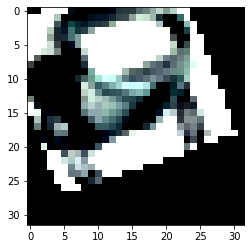

In [6]:
for images, labels in train_gen:
    print(images[0])
    plt.imshow(images[0])
    break

In [7]:
model = densenet_model(classes=n_classes, nb_filter=nb_filter, shape=img_shape, growth_rate=growth_rate, nb_layers=nb_layers, reduction=reduction)

In [8]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
meta_optimizer = tf.keras.optimizers.Adam()

In [9]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [10]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(tf.cast(images, tf.float32), training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    return predictions


@tf.function
def meta_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(tf.cast(images, tf.float32), training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    return gradients

@tf.function
def test_step(images, labels):
    predictions = model(tf.cast(images, tf.float32), training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
    return predictions

In [11]:
# create summary writers
train_summary_writer = tf.summary.create_file_writer('results/summaries/train/' + identifier)
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)

min_loss = 100
min_loss_acc = 0
patience = 0

In [ ]:
print("starting training")
time_record = ''
for epoch in range(epochs):
    time_start = time.time()
    
    batches = 0
    while not ((batches + task_train_size + meta_train_size) >= train_size / batch_size):
        # get the weights of the initial model that will do the meta learning
        meta_model_weights = model.get_weights()

        # train on the task (one epoch)
        task_batches = 0
        for images, labels in train_gen:
            batches += 1
            train_step(images, labels)
            task_batches += 1
            if task_batches >= task_train_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

        # test on the validation set the improvement achieved on one task for the meta learning
        meta_batches = 0
        sum_gradients = np.zeros_like(model.trainable_variables)
        for images, labels in train_gen:
            batches += 1
            gradients = meta_step(images, labels)
            gradients = np.array([np.array(x) for x in gradients])
            sum_gradients = sum_gradients + gradients
            meta_batches += 1
            if meta_batches >= meta_train_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

        # set weights of the model to the weights of the original model
        model.set_weights(meta_model_weights)                        

        # update the weights of the meta learning model using the loss obtained from testing
        meta_optimizer.apply_gradients(zip(sum_gradients, model.trainable_variables))
            

    # get the weights of the initial model that will do the meta learning
    meta_model_weights = model.get_weights()

    # train on the task (one epoch)
    task_batches = 0
    for images, labels in train_gen:
        batches += 1
        train_step(images, labels)
        task_batches += 1
        if task_batches >= task_train_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    # test the newly trained model on the training set
    batches = 0
    all_predictions = np.array([]).reshape(0, n_classes)
    all_labels = np.array([]).reshape(0, n_classes)
    for test_images, test_labels in test_gen:
        test_predictions = test_step(test_images, test_labels)
        all_predictions = np.vstack((all_predictions, test_predictions))
        all_labels = np.vstack((all_labels, tf.one_hot(test_labels, n_classes)))
        batches += 1
        if batches >= test_size / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    
    # set weights of the model to the weights of the original model
    model.set_weights(meta_model_weights)                        

    time_finish = time.time()
    end_time = (time_finish-time_start)
    time_record = time_record + '{:.3f} s \n'.format(end_time)

    if (epoch % log_freq == 0):
        print ('Epoch: {}, Train Loss: {}, Train Acc:{}, Test Loss: {}, Test Acc: {}, Time: {} s'.format(
               epoch,
               train_loss.result(),
               train_accuracy.result()*100,
               test_loss.result(),
               test_accuracy.result()*100,
               end_time))

        if (test_loss.result() < min_loss):    
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            # serialize weights to HDF5
            model.save_weights(models_directory + "best{}.h5".format(identifier))
            min_loss = test_loss.result()
            min_loss_acc = test_accuracy.result()
            patience = 0
        else:
            patience += 1

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
            #tf.summary.image('Confusion Matrix', image, step=epoch)
            train_loss.reset_states()           
            train_accuracy.reset_states()           

        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            test_loss.reset_states()           
            test_accuracy.reset_states()   
            # save confusion matrix
            con_mat = tf.math.confusion_matrix(
                labels=np.argmax(all_labels, axis=1), 
                predictions=np.argmax(all_predictions, axis=1),
                num_classes=n_classes).numpy()
            con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
            con_mat_df = pd.DataFrame(con_mat_norm,
                                 index = classes, 
                                 columns = classes)
            figure = plt.figure(figsize=(8, 8))
            sns.heatmap(con_mat_df, annot=False,cmap=plt.cm.Blues)
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close(figure)
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
            tf.summary.image('Confusion Matrix', image, step=epoch)

    if patience >= max_patience:
        break

with open(os.path.join('results/', identifier), "w") as file1:
    file1.write(time_record)

starting training
Epoch: 0, Train Loss: 4.450913429260254, Train Acc:3.929832935333252, Test Loss: 4.604872703552246, Test Acc: 1.090000033378601, Time: 72.50628709793091 s
Epoch: 1, Train Loss: 4.213759899139404, Train Acc:6.668526649475098, Test Loss: 4.604650974273682, Test Acc: 1.5399999618530273, Time: 36.012362241744995 s
Epoch: 2, Train Loss: 4.4450554847717285, Train Acc:6.310211658477783, Test Loss: 4.604489326477051, Test Acc: 1.5199999809265137, Time: 36.2438428401947 s
Epoch: 3, Train Loss: 4.720391750335693, Train Acc:6.385522842407227, Test Loss: 4.604438781738281, Test Acc: 1.0099999904632568, Time: 45.52060055732727 s
